<div style="text-align: center; font-size:200%"> Tutorial: Analyze What Makes a Good Valorant Player </div>
<br>
<div style="text-align: center; font-size:200%"> with These Cool Python Datascience Techniques! </div>
<br>
<div style="text-align: center; font-size:200%"> CMSC 320 </div>
<br>
<div style="text-align: center; font-size:200%"> Michael Suehle and Nathan Valencia </div>

# Introduction
With the end of the <a href="https://playvalorant.com/en-us/news/esports/announcing-the-2021-valorant-champions-tour/">first international Valorant competitive event</a> finally coming to a close and with there being several different highlight moments that will define the scene for many years to come, there are a lot of things that can be digested from a statistician’s point of view.  When looking at a top down view of a game, one would see that there are a lot of intricacies to team play including compositions, shotcalling, memorizing a team’s gameplan, individual explosive moments, utility combinations, divisions of members, and so much more.  But what describes a good player?  What makes a person stand out on the characters they perform on?  And how does this impact a game?  These are the questions we will be looking at when discussing this topic and using the data from the <a href="https://www.vlr.gg/stats">vlr website</a>.  There are a lot more things to come up from a player than just kills, so let us bring into the limelight the kinds of things that people should be more aware of when discussing this game and its athletes.

# The Data
The first thing that we need to do is grab usable information and data to help support our arguments and findings.  The best place to do this is <a href="https://www.vlr.gg/stats">vlr.gg</a>.  This is an unofficial website that keeps tracks of several different things that happen in game for each player.   However, there is a main statline of what this website keeps tracks of and that is how good a person can shoot at another person without dying.  The main stats that are kept on this website are as follows: kd, acs, adr, kpr, apr, fkpr, fdpr, hs%, cl%. Each of which will be discussed below: <br>
KD: Kills / Death<br>
ACS: Average Combat Score (Kills (point distribution by how many people are left) + Multikills (Additional 50 points for each kill after 1) + total damage).  Then it is averaged for each round at the end of the game<br>
ADR: Damage / Round<br>
KPR: Kills / Round<br>
APR: Assists / Round<br>
FKPR: First kill / Round<br>
FDPR: First Death / Round<br>
HS%: Headshot Kills / Kill<br>
CL%: Clutches / rounds in ‘x’ vs 1 situation<br>
<br>
These stats will help gather a better outline of the players and how they perform on respective rolls.  The last thing that will be included in the graph are the agents/heroes each person primarily played.  We will count the top 3 agents that a person played.  This will reign in a lot of the data and flexible players who can play a multitude of roles will be accounted for each character they use dependent on the role we are analyzing.  So before going through each of the datasets, we need to establish those roles and what they are known for.
<br>
The first up are Sentinels.  These are the people that are expected to lockdown avenues and sites as well as expected to watch flanks so the team can focus on their main objectives.  They aren’t looked at to get a lot of kills and are mainly looked to for helping set up the rest of the team.  The next role would be the controllers.  These kinds of characters control the area that is being fought over by placing smokes in key areas to slow the aggression of the enemy team and allow the rest of the team to move safely from destination to destination.  These types of players are also not expected to get many kills and are reasonably used to help control areas and stay alive to keep controlling places that need presence.  Initiators are known for their information gathering skills.  They are said to “initiate” the fight by scanning areas, flashing out corners, de-buffing the enemy team, scouting portions of the map and in general being the first sets of util that set up an execute of a plan.  These people focus on their initial usage of utility but can also get kills.  As such, they are seen as the second fraggers behind the main stars of the show.  And those would be the duelists.  Duelists’ main job is to secure map control through the elimination of the opposing team.  They are the first bodies to take fights and should always be the first out of main chokes and areas.  They are equipped with utility to help themselves secure kills as well as push up deeper into enemy territory and hold aggressive angles.  The team helps set them up to succeed in getting into positions to get those kills, but the actual act of dispatching the enemy is normally done by this role.

## Data Collection
Here we scrape the website for the table we need using <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> and store in a <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide">pandas dataframe</a>. We do this easily using code from <a href="https://github.com/cmsc320/spring2022/blob/main/project1/README.md">project 1</a>. HERE we should explain why we are using the specific table we use.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np


Note that the agents are not read in. We should do something about that
also note that clutch percentage has missing data where it should be 0, so we will will that in too

## Data Wrangling
Notice how the 'Agents' column is missing values? That is because vlr.gg uses images to display the agents. Below, we add the agent images to our Dataframe and set the missing Clutch Percent (CL%) to 0% since that is what its value should be if you compute it from the Clutches (CL) column.

Now, let's extract the names of each of the agents from their html image tag and put that in the 'Agents' column.

Now let's make a column for the agent classes. To help with this, we use a hardcoded 'classes' dictionary that maps agents to their respective classes.

Almost ready for processing! Finally, let's separate the player names from their teams.

In [2]:
#now im gonna try doing the same stuff above but for each character
agent_classes = {'phoenix':'duelist',
           'jett':'duelist',
           'viper':'controller',
           'sova':'initiator',
           'cypher':'sentinel',
           'brimstone':'controller',
           'sage':'sentinel',
           'omen':'controller',
           'raze':'duelist',
           'breach':'initiator',
           'astra':'controller',
           'chamber':'sentinel',
           'kayo':'initiator',
           'killjoy':'sentinel',
           'neon':'duelist',
           'reyna':'duelist',
           'skye':'initiator',
           'yoru':'duelist'}

all_agents = list(agent_classes.keys())


agent_data = dict()

for agent in all_agents:
    table_string = 'https://www.vlr.gg/stats/?event_group_id=all&event_id=926&series_id=all&region=all&country=all&min_rounds=1&min_rating=0&agent='+agent+'&map_id=all&timespan=90d'
    request = requests.get(table_string) 
    root = BeautifulSoup(request.content, 'html.parser')
    table = root.find('table')
    agent_frame = pd.read_html(str(table))[0]
    
    #change NaN in CL% to 0
    agent_frame['CL%'] = agent_frame['CL%'].replace(np.nan, '0%')
    
    #fill in agent name
    agent_frame['Agents'] = agent_frame['Agents'].replace(np.nan, agent)
    
    #add class
    class_col = [agent_classes[agent] for i in range(0,len(agent_frame))]
    agent_frame['Class'] = class_col
    
    #add team column
    teams = []
    names = []
    for i, row in agent_frame.iterrows():
        name_team = row['Player'].split(' ')
        names.append(name_team[0])
        if len(name_team) > 1:
            teams.append(name_team[1])
        else:
            teams.append('')

    agent_frame.drop(columns=['Player'])
    agent_frame['Player'] = names
    agent_frame['team'] = teams
    
    agent_data[agent]=agent_frame


In [3]:
agent_data['breach'].head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL%,CL,KMax,K,D,A,FK,FD,Class,team
0,JonahP,breach,43,228.5,1.09,81%,143.8,0.86,0.14,0.12,...,0%,0/3,25,37,34,6,5,2,initiator,TGRD
1,Crws,breach,61,202.7,0.91,67%,134.8,0.69,0.20,0.07,...,22%,2/9,18,42,46,12,4,4,initiator,XIA
2,Jamppi,breach,111,194.8,1.07,69%,124.6,0.71,0.11,0.12,...,10%,1/10,19,79,74,12,13,8,initiator,TL
3,Boaster,breach,20,169.0,0.71,60%,113.1,0.60,0.25,0.05,...,0%,0/2,12,12,17,5,1,2,initiator,FNC
4,Klaus,breach,18,169.0,0.71,67%,109.1,0.56,0.11,0.00,...,0%,0/2,10,10,14,2,0,0,initiator,KRÜ


In [4]:
combined_data = pd.DataFrame()

for agent in all_agents:
    agent_frame = agent_data[agent]
    combined_data = pd.concat([combined_data,agent_frame])

combined_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL%,CL,KMax,K,D,A,FK,FD,Class,team
0,H1ber,jett,20,277.0,1.13,80%,170.7,0.90,0.15,0.30,...,0%,0/1,18,18,16,3,6,3,duelist,VIT
1,ScreaM,jett,118,270.8,1.33,71%,168.4,0.92,0.14,0.23,...,17%,1/6,23,109,82,17,27,12,duelist,TL
2,Sayaplayer,jett,87,266.8,1.50,72%,164.9,0.97,0.10,0.21,...,0%,0/12,27,84,56,9,18,12,duelist,TGRD
3,aspas,jett,199,244.8,1.27,76%,148.3,0.86,0.14,0.15,...,5%,1/19,27,172,135,27,30,34,duelist,LLL
4,Jamppi,jett,85,244.0,1.21,69%,163.5,0.88,0.20,0.21,...,29%,2/7,33,75,62,17,18,21,duelist,TL


# Data Processing and Analysis
To create the plots for our analysis, we use the <a href="https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html">pyplot module of matplotlib</a>.
First, let's start by looking at the overall frequency and average combat scores (ACS) for each class. The code below creates two histograms that conveys this information.

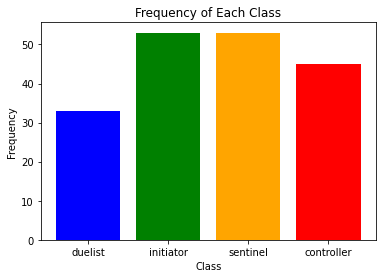

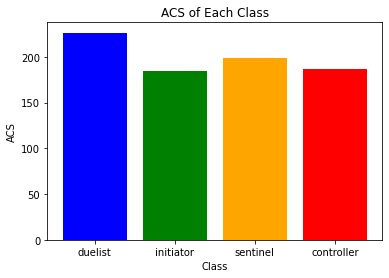

In [17]:
import matplotlib.pyplot as plt
class_colors = {'duelist':'blue', 'initiator':'green', 'sentinel':'orange', 'controller':'red'}
#lets plot the classes and their acs
classes_acs = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}
classes_freq = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}

for i, row in combined_data.iterrows():
    classes = row['Class']
    classes_acs[classes] += row['ACS']
    classes_freq[classes] += 1
        
for key in classes_acs.keys():
    classes_acs[key] = classes_acs[key] / classes_freq[key]

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class')
plt.bar(classes_acs.keys(), classes_freq.values(), color=class_colors.values())
plt.show()
plt.xlabel('Class')
plt.ylabel('ACS')
plt.title('ACS of Each Class')
plt.bar(classes_acs.keys(), classes_acs.values(), color=class_colors.values())
plt.show()

Imma plot the frequency of characters now by doing similar thing

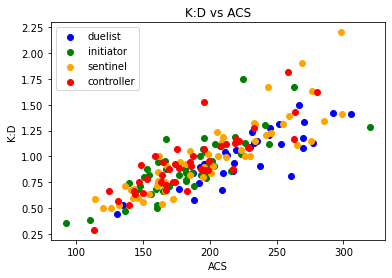

In [18]:
#imma plot ACS and K:D for everyone and label them with class
#here I store the relevant information in a class_data dict() which maps classes to their kd and acs observations
import matplotlib.pyplot as plt
class_colors = {'duelist':'blue', 'initiator':'green', 'sentinel':'orange', 'controller':'red'}
plt.figure()
class_data = {'duelist':[[],[]], 'initiator':[[],[]], 'sentinel':[[],[]], 'controller':[[],[]]}

for agent in all_agents:
    agent_frame = agent_data[agent]
    kd = agent_frame['K:D']
    acs = agent_frame['ACS']
    agent_class = agent_classes[agent]
    
    class_data[agent_class][0] = class_data[agent_class][0] + list(kd)
    class_data[agent_class][1] = class_data[agent_class][1] + list(acs)
    
for classes in class_data.keys():
    kd = class_data[classes][0]
    acs = class_data[classes][1]
    plt.scatter(acs, kd, c=class_colors[classes], label=classes)

        
plt.title('K:D vs ACS')
plt.xlabel('ACS')
plt.ylabel('K:D')
plt.legend()

plt.show()

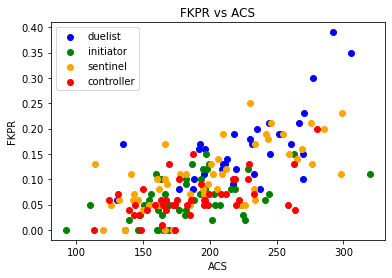

In [19]:
#imma plot ACS and FKPR for everyone and label them with class

plt.figure()
class_data = {'duelist':[[],[]], 'initiator':[[],[]], 'sentinel':[[],[]], 'controller':[[],[]]}

for agent in all_agents:
    agent_frame = agent_data[agent]
    fkpr = agent_frame['FKPR']
    acs = agent_frame['ACS']
    agent_class = agent_classes[agent]

    class_data[agent_class][0] = class_data[agent_class][0] + list(fkpr)
    class_data[agent_class][1] = class_data[agent_class][1] + list(acs)
    
for classes in class_data.keys():
    fkpr = class_data[classes][0]
    acs = class_data[classes][1]
    plt.scatter(acs, fkpr, c=class_colors[classes], label=classes)

        
plt.title('FKPR vs ACS')
plt.xlabel('ACS')
plt.ylabel('FKPR')
plt.legend()

plt.show()

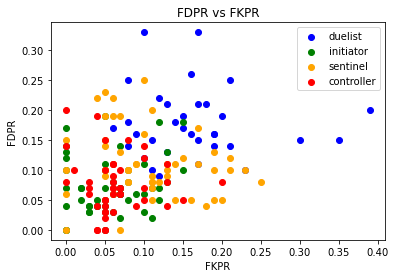

In [20]:
#imma plot FKPR and FDPR for everyone and label them with class

plt.figure()
class_data = {'duelist':[[],[]], 'initiator':[[],[]], 'sentinel':[[],[]], 'controller':[[],[]]}

for agent in all_agents:
    agent_frame = agent_data[agent]
    fdpr = agent_frame['FDPR']
    fkpr = agent_frame['FKPR']
    agent_class = agent_classes[agent]

    class_data[agent_class][0] = class_data[agent_class][0] + list(fdpr)
    class_data[agent_class][1] = class_data[agent_class][1] + list(fkpr)
    
for classes in class_data.keys():
    fdpr = class_data[classes][0]
    fkpr = class_data[classes][1]
    plt.scatter(fkpr, fdpr, c=class_colors[classes], label=classes)

        
plt.title('FDPR vs FKPR')
plt.xlabel('FKPR')
plt.ylabel('FDPR')
plt.legend()

plt.show()

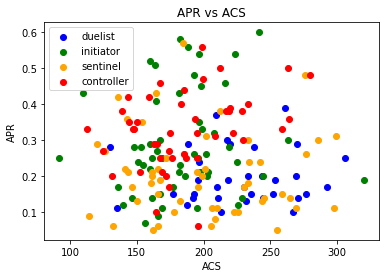

In [21]:
#imma plot ACS and FKPR for everyone and label them with class
# thinking we can cut this

plt.figure()
class_data = {'duelist':[[],[]], 'initiator':[[],[]], 'sentinel':[[],[]], 'controller':[[],[]]}

for agent in all_agents:
    agent_frame = agent_data[agent]
    apr = agent_frame['APR']
    acs = agent_frame['ACS']
    agent_class = agent_classes[agent]
    
    class_data[agent_class][0] = class_data[agent_class][0] + list(apr)
    class_data[agent_class][1] = class_data[agent_class][1] + list(acs)
    
for classes in class_data.keys():
    apr = class_data[classes][0]
    acs = class_data[classes][1]
    plt.scatter(acs, apr, c=class_colors[classes], label=classes)

        
plt.title('APR vs ACS')
plt.xlabel('ACS')
plt.ylabel('APR')
plt.legend()

plt.show()

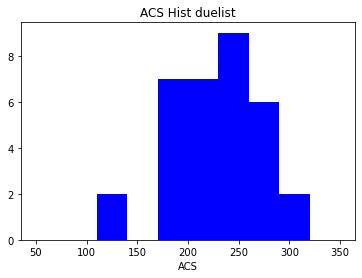

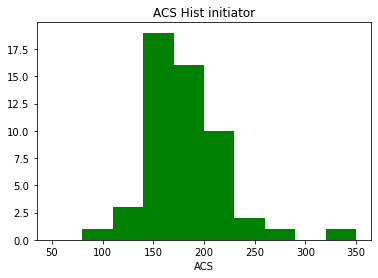

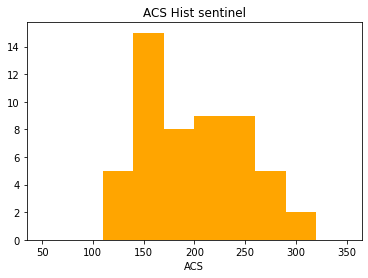

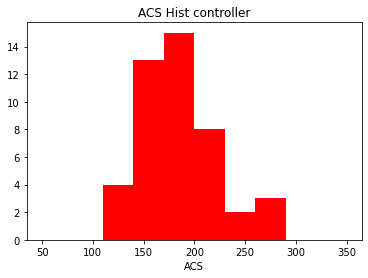

In [22]:
class_acs = {'duelist':[], 'initiator':[], 'sentinel':[], 'controller':[]}


for agent in all_agents:
    
    agent_frame = agent_data[agent]
    acs = agent_frame['ACS']
    agent_class = agent_classes[agent]
    
    class_acs[agent_class] = class_acs[agent_class] + list(acs)

for classes in class_acs.keys():
    plt.figure()
    plt.hist(class_acs[classes],range=(50,350),bins=10,color=class_colors[classes])

    title = 'ACS Hist ' + classes
    plt.title(title)
    plt.xlabel('ACS')

    plt.show()


## Predictions and Hypothesis Testing
In this section we use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">LinearRegression module from sklearn</a> and the <a href="https://www.statsmodels.org/stable/api.html">api module from statsmodels</a>.

Notes: here let's do linear regression on stuff like ACS vs whatever (since those are mostly linear) and then kmeans on FDPR vs FKPR (since those seem to be in a group).

Then we can conduct a T-test to evalute if the preformance of the model is statistically significant.

In [23]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf


combined_data_dummies = pd.get_dummies(combined_data, columns=['Class'])

reg = smf.ols(formula='FKPR ~ Class_duelist + Class_initiator + Class_sentinel + Class_controller + ACS*Class_duelist + ACS*Class_initiator + ACS*Class_sentinel + ACS*Class_controller', data=combined_data_dummies).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   FKPR   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     35.94
Date:                Sun, 15 May 2022   Prob (F-statistic):           7.44e-31
Time:                        21:18:47   Log-Likelihood:                 320.49
No. Observations:                 184   AIC:                            -625.0
Df Residuals:                     176   BIC:                            -599.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0498 

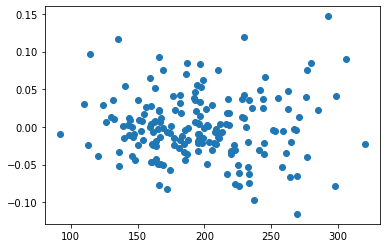

In [24]:
plt.figure()
X = combined_data['ACS']
Y = reg.resid
plt.scatter(X,Y)

(array([ 2.,  8., 21., 44., 52., 32., 12.,  9.,  3.,  1.]),
 array([-0.11540089, -0.08917184, -0.06294279, -0.03671374, -0.01048469,
         0.01574436,  0.04197341,  0.06820246,  0.09443151,  0.12066056,
         0.14688961]),
 <BarContainer object of 10 artists>)

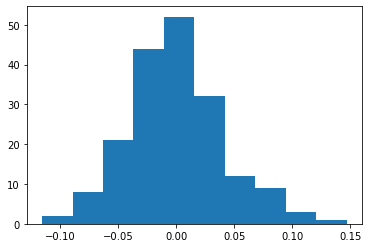

In [25]:
plt.hist(reg.resid)

Trying KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as ms
import sklearn.metrics as met
from scipy import stats

#trying 3 since that is what they do in the tutorial, could try again with other k-values to try and improve accuracy
kneigh = KNeighborsClassifier(n_neighbors=4) 

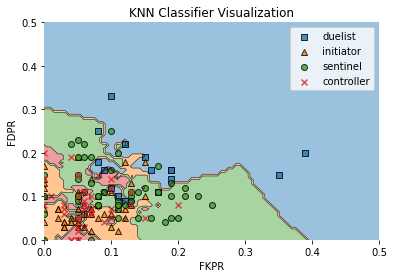

Average Accuracy for duelist: 0.6837789661319075
Average Accuracy for initiator: 0.29047619047619044
Average Accuracy for sentinel: 0.5303981732553161
Average Accuracy for controller: 0.07291666666666667


In [92]:
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

cmap_light = ListedColormap(['lightblue', 'lightgreen', 'lightorange', 'lightred'])
cmap_bold = ['darkblue', 'darkgreen', 'darkorange', 'darkred']
class_codes = {'duelist':0, 'initiator':1, 'sentinel':2, 'controller':3}

kf = ms.KFold(n_splits=10)
knn_accuracies = {'duelist':[], 'initiator':[], 'sentinel':[], 'controller':[]}
ind = pd.DataFrame(combined_data[['FKPR','FDPR','Class']])
dep = np.array([class_codes[i] for i in combined_data['Class']])
first = True

for train_index, test_index in kf.split(ind):
    #divide training and testing data base on the fold
    ind_train = ind.iloc[train_index].drop(columns='Class')

    ind_test = {'duelist':ind.iloc[test_index][ind.iloc[test_index]['Class']=='duelist'], 
                'initiator':ind.iloc[test_index][ind.iloc[test_index]['Class']=='initiator'], 
                'sentinel':ind.iloc[test_index][ind.iloc[test_index]['Class']=='sentinel'],
                'controller':ind.iloc[test_index][ind.iloc[test_index]['Class']=='controller']}
    dep_train= dep[train_index]
    dep_test = dep[test_index]
    
    #fit and test model
    clf = kneigh.fit(ind_train, dep_train)
    
    for classes in class_codes.keys():
        ind_test[classes] = ind_test[classes].drop(columns='Class').dropna()
        
        if len(ind_test[classes]) > 0:
            dep_pred = clf.predict(ind_test[classes])
            dep_test = [class_codes[classes]]*len(dep_pred)
    
            #store the accuracies
            knn_accuracies[classes].append(met.accuracy_score(dep_test, dep_pred))
    
    if first:
        #plots
        ax = plot_decision_regions(ind_train.to_numpy(), dep_train, clf=clf, legend=2)
        # Adding axes annotations
        plt.xlabel('FKPR')
        plt.ylabel('FDPR')
        plt.title('KNN Classifier Visualization')
        plt.xlim([0,0.5])
        plt.ylim([0,0.5])
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['duelist', 'initiator', 'sentinel', 'controller'])
        plt.show()
        first = False

for classes in knn_accuracies.keys():
    print("Average Accuracy for "+classes+": " + str(sum(knn_accuracies[classes])/len(knn_accuracies[classes]))) #print average accuracy of the 10 folds
    #print("Estimated Standard Error of Accuracy: " + str(stats.sem(knn_accuracies[classes])))

# Insights

# Additional Resources